### Clustering the sequencing data produced by https://arxiv.org/pdf/2406.12955 - 'End to End Coding Scheme for DNA-based Data Storage with Nanopore Sequenced Reads'

In [261]:
%load_ext autoreload
%autoreload 
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [262]:
import random
from clustering import Clustering
import utils
import uuid
import matplotlib.pyplot as plt
from strand_reconstruction import align
from Levenshtein import distance
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
def read_strands_from_file(filepath):

    with open(filepath, 'r') as f:
        lines = f.readlines()

    return [line.strip() for line in lines if line.startswith(('A', 'C', 'T', 'G'))] 


In [100]:
original_strands_filepath = r"C:\Users\Parv\Doc\RA\Projects\sequencingData\End_to_end_experiment\oligos.fasta"

sequenced_strands_filepath = r"C:\Users\Parv\Doc\RA\Projects\sequencingData\End_to_end_experiment\clustered_read_segments\file-1_acc-true_passQ-true\forward\RX__file=1_accBaCa=true_passQ=true_filter=true_forward_.txt"

reverse_sequenced_strands_filepath = r"C:\Users\Parv\Doc\RA\Projects\sequencingData\End_to_end_experiment\clustered_read_segments\file-1_acc-true_passQ-true\backward\RX__file=1_accBaCa=true_passQ=true_filter=true_backward_.txt"

original_strands = utils.read_synthesized_strands_from_file(file_path=original_strands_filepath)[0]
sequenced_strands = read_strands_from_file(sequenced_strands_filepath)
reverse_sequenced_strands = read_strands_from_file(reverse_sequenced_strands_filepath)

In [71]:

# Combining the split original strands due to newline characters

original_strands_ = []

for ind, i in enumerate(original_strands):
    if ind + 2 == len(original_strands):
        break

    original_strands_.append(
        original_strands[ind].strip() + original_strands[ind + 1].strip() + original_strands[ind + 2].strip())
    

In [ ]:
# Searching for the file-specific oligos using the primers

forward_primer = "TCGAAAGCGTGGACAAACAA"
reverse_primer = "AAGCCGAATTAAAGCGCACT"

In [88]:
reverse_primer_c = utils.reverse_complement(reverse_primer)

In [92]:
reference_strands = []  # Reference strands for file 1

In [93]:
for i in original_strands_:
    if i[:20] == forward_primer and i[-20:] == reverse_primer_c:
        reference_strands.append(i)

In [106]:
reference_strands_sampled = reference_strands[:1004]

In [198]:
copy_pool = []
copy_pool_reference_pointers = []
copies_per_reference = np.zeros(len(reference_strands_sampled))

In [199]:

threshold = 40

for ind, sequenced_strand in tqdm(
    enumerate(sequenced_strands), total=len(sequenced_strands)):
    for ref_ind, reference_strand in enumerate(reference_strands_sampled):
        if copies_per_reference[ref_ind] > 15:
            continue
        if distance(sequenced_strand, reference_strand) < threshold:
            copy_pool.append(sequenced_strand)
            copy_pool_reference_pointers.append(ref_ind)
            copies_per_reference[ref_ind] += 1
            break

    if sum(
        [1  for i in copies_per_reference if i > 5]) == len(reference_strands):
        break

    if (ind + 1) % 1000 == 0:
        print(sum([1 for i in copies_per_reference if i < 5]))


  0%|          | 0/494026 [00:00<?, ?it/s]

951
888
838
780
727
668
616
564
512
454
391
336
280
230
174
120
116
116
116


KeyboardInterrupt: 

In [201]:
copy_pool_reverse = []
copy_pool_reverse_reference_pointers = []
copies_per_reference_reverse = np.zeros(len(reference_strands_sampled))

In [202]:

threshold = 40

for ind, sequenced_strand in tqdm(
    enumerate(reverse_sequenced_strands), total=len(sequenced_strands)):
    rev_seq = utils.reverse_complement(sequenced_strand)
    for ref_ind, reference_strand in enumerate(reference_strands_sampled):
        if copies_per_reference_reverse[ref_ind] > 15:
            continue
        if distance(rev_seq, reference_strand) < threshold:
            copy_pool_reverse.append(sequenced_strand)
            copy_pool_reverse_reference_pointers.append(ref_ind)
            copies_per_reference_reverse[ref_ind] += 1
            
    if sum(
        [1  for i in copies_per_reference if i > 5]) == len(reference_strands):
        break

    if (ind + 1) % 1000 == 0:
        print(sum([1 for i in copies_per_reference_reverse if i < 5]))

  0%|          | 0/494026 [00:00<?, ?it/s]

957
910
859
815
769
722
673
624
577
536
487
434
383
339
294
248
205
159
113
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78


KeyboardInterrupt: 

In [230]:
copy_pool_reverse[0]

'AAGCCGAATTAAAGCGCACTTGCGTCGCTAATCATCCAGCCCACAGCGATAAAACCGGTAGAGAAATTTCCTGATCCTTTCGGAATGCCTGGGGGGAAGCGTCAGGCTATCAACTCGTCACCAGTTGGGAGTTGTTTGTCCACGCTTTCGA'

In [232]:
reverse_primer

'AAGCCGAATTAAAGCGCACT'

In [231]:
forward_primer

'TCGAAAGCGTGGACAAACAA'

In [203]:
sum([1 for i in (copies_per_reference + copies_per_reference_reverse) if i < 1])

10

We have 10 strands without any copies. 33 strands with less than 5. More than enough to start the experiment. Let's remove all the adapters.

In [206]:
print(reference_strands_sampled[0][:20], forward_primer)
print(reference_strands_sampled[0][-20:], reverse_primer_c)

TCGAAAGCGTGGACAAACAA TCGAAAGCGTGGACAAACAA
AGTGCGCTTTAATTCGGCTT AGTGCGCTTTAATTCGGCTT


In [207]:
# Removing the adapters from the reference strands
reference_strands_cleaned = [i[20:][:-20] for i in reference_strands_sampled]
reference_ids = [str(uuid.uuid4()) for i in range(len(reference_strands_cleaned))]

In [291]:
# Let us select 10 repeats from each forward and reverse, and then add a random sample of other strands

copies_per_reference_final = np.zeros(len(reference_strands_cleaned))
strand_pool = []

for ind, reference_ind in enumerate(copy_pool_reference_pointers):
    if copies_per_reference_final[reference_ind] < 10:
        strand_pool.append(copy_pool[ind])
        copies_per_reference_final[reference_ind] += 1

for ind, reference_ind in enumerate(copy_pool_reverse_reference_pointers):
    if copies_per_reference_final[reference_ind] < 20:
        strand_pool.append(copy_pool_reverse[ind])
        copies_per_reference_final[reference_ind] += 1

Text(0.5, 1.0, 'Repeats per reference in experiment')

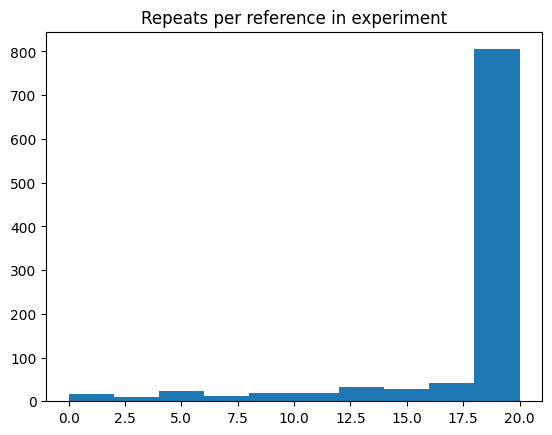

In [292]:
plt.hist(copies_per_reference_final)
plt.title("Repeats per reference in experiment")

In [293]:
# Now we add random noise
random_noise_strands = [utils.create_random_strand(150) for i in range(5000)]
strand_pool.extend(random_noise_strands)
random.shuffle(strand_pool)
len(strand_pool)

23081

In [294]:
# Creating strand pool ids

strand_pool_ids = [str(uuid.uuid4()) for i in range(len(strand_pool))]

In [249]:
# Maybe manually remove the adapters first

In [326]:
clustering = Clustering(
    strand_pool=strand_pool, reference_length=150, original_strands=reference_strands_cleaned,
    original_strand_ids=reference_ids, strand_pool_ids=strand_pool_ids, front_adapter=forward_primer, reverse_adapter=reverse_primer, distance_threshold=15
    )

Filtering strands by length
0.06862787574195225 strands filtered out
Removing adapters


  0%|          | 0/21497 [00:00<?, ?it/s]

100%|██████████| 21497/21497 [00:00<00:00, 1806225.15it/s]


Clustering strands
Total strands 21497


100%|██████████| 21497/21497 [03:56<00:00, 91.02it/s] 


Number of clusters = 7850
Clusters are sorted
Orientation fixed in the strand pool
Generating 1054 candidates


100%|██████████| 1054/1054 [01:16<00:00, 13.83it/s]


Fixing candidate orientations
0.5151802656546489 candidates are reversed
Evaluating candidates


1054it [00:10, 98.49it/s]


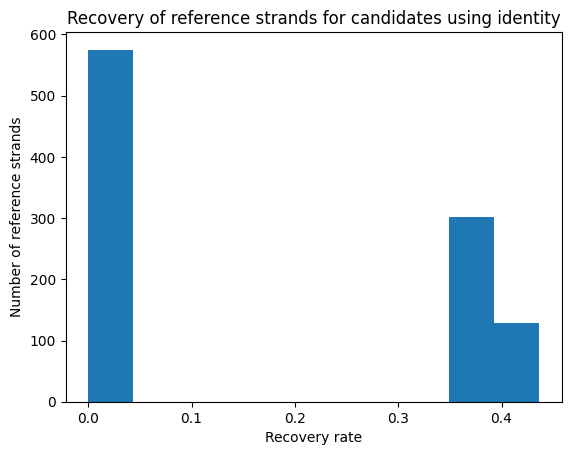

In [327]:
result_dict = clustering.run_pipeline(remove_adapters=True, fix_orientation=True)

In [314]:
candidates = clustering.fix_candidate_orientations(candidates=clustering.candidates)

0.5151802656546489 candidates are reversed


In [328]:
evaluation_dict = clustering.evaluate_candidates(metric='edit_distance_ratio', candidates=candidates)

1054it [00:03, 345.92it/s]


Text(0.5, 1.0, 'Reference recoveries post clustering')

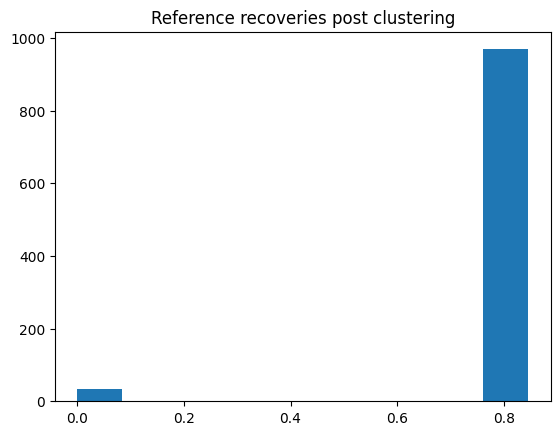

In [329]:
plt.hist(evaluation_dict['reference_recoveries'])
plt.title("Reference recoveries post clustering")

In [321]:
len([i for i in evaluation_dict['reference_recoveries'] if i == 1.0])/1004

0.8346613545816733

In [308]:
clustering.clusters

[[1725,
  2996,
  3197,
  3770,
  3775,
  5138,
  8647,
  9243,
  9965,
  11043,
  11310,
  11809,
  12531,
  12679,
  13252,
  14403,
  14836,
  15280,
  18944,
  19032],
 [106,
  592,
  3618,
  4709,
  5510,
  7101,
  7854,
  8720,
  12134,
  12675,
  12685,
  12845,
  14086,
  15622,
  16205,
  16304,
  17458,
  17975,
  18999,
  19397],
 [340,
  1532,
  2316,
  2993,
  3183,
  4009,
  4154,
  5355,
  7942,
  8334,
  11587,
  13475,
  14485,
  14586,
  15132,
  16705,
  17900,
  17908,
  19227,
  19741],
 [242,
  2750,
  3092,
  4070,
  5004,
  5511,
  5574,
  7619,
  9166,
  9814,
  14444,
  14911,
  15157,
  15890,
  16875,
  16962,
  18287,
  19444,
  19525,
  19913],
 [213,
  375,
  479,
  3158,
  3453,
  3613,
  5979,
  7573,
  8234,
  9199,
  12138,
  12216,
  12267,
  13427,
  15102,
  15234,
  16564,
  17361,
  18011,
  20034],
 [829,
  1481,
  2405,
  3964,
  7521,
  8801,
  10873,
  12429,
  12490,
  13113,
  14255,
  15469,
  16296,
  17097,
  17275,
  17418,
  17497,
  1

In [311]:
clustering.reversed_markers

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [310]:
for ind, i in enumerate(evaluation_dict['reference_strand_indices']):

    print(align(clustering.candidates[i], reference_strands_sampled[i]))
    print(distance(clustering.candidates[i], reference_strands_sampled[i]))
    
    for j in clustering.clusters[ind]:
        #print(distance(clustering.strand_pool[ind[j], clustering.strand_pool[j+2]))
        print(clustering.strand_pool[j])
        print(utils.reverse_complement(clustering.strand_pool[j]))
        print()
    break

target            0 AA-GCCG---A-ATTAA-A-G-CG---CA--C-TT-GAT--C--TG--TA-CCCC-----
                  0 ||-||-|---|-|--||-|-|-||---||--|-|--|-|--|--||--||-||||-----
query             3 AAAGC-GTGGACA--AACAAGGCGGTTCATACGT-CG-TTGCCCTGAATAACCCCAAGAA

target           33 T--CTCATGAT-GTGCA-T-GAAACGCCTAGTATTACG-GCCTACAGCTATC--CAGT-A
                 60 |--||||||||-||-|--|-||---||--|--|--|||-||-|-||--|-||--|-|--|
query            58 TGGCTCATGATCGT-C-GTCGA---GC--A--A--ACGAGC-T-CA--T-TCTGC-G-GA

target           84 AACC-A--ACAGACTACGA-G-GT----G-AGGGTT-GACGGGGTGCGAATCGCTCTT--
                120 |-|--|--|||--||-|-|-|-||----|-||--||-||-|---||||---|--|-||--
query           100 A-C-GATGACA--CT-C-AAGCGTTTCTGCAG--TTTGA-G---TGCG---C--T-TTAA

target          131 TGTTTGTCCACG-CTT 146
                180 |-|----|---|-||| 196
query           142 T-T----C---GGCTT 150

81
AAGCCGAATTAAAGCGCACTAGCAATGAATGTTGCTCTTTGCTGAAAACCCCGACCATACCTCGCACACGCTATGACCAACGGTTAGATCCTGTACGTGATAACTAATGTGTCGAGTGAGGTGACCGTTGTTTGTCCACGC

In [53]:
evaluation_dict = clustering.evaluate_candidates(metric='edit_distance_ratio')

1150it [00:03, 335.76it/s]


(array([578.,   0.,   0.,   0.,   0.,   0.,   0., 461.,   1.,  60.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

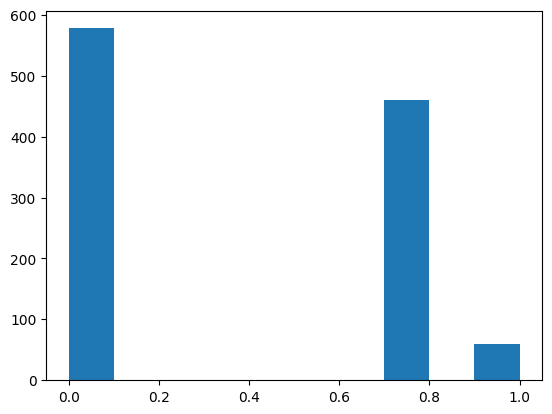

In [ ]:
plt.hist(evaluation_dict['reference_recoveries'])

In [241]:
evaluation_dict['reference_recoveries']

array([0.86462882, 0.69456067, 0.675     , 0.87931034, 0.87445887,
       0.79069767, 0.        , 0.85714286, 0.        , 0.        ,
       0.        , 0.        , 0.91213389, 0.        , 0.87445887,
       0.84955752, 0.67782427, 0.        , 0.89361702, 0.675     ,
       0.86956522, 0.82352941, 0.91666667, 0.82882883, 0.69166667,
       0.89830508, 0.        , 0.675     , 0.83408072, 0.675     ,
       0.675     , 0.85964912, 0.675     , 0.        , 0.80184332,
       0.        , 0.675     , 0.86580087, 0.78899083, 0.68333333,
       0.80542986, 0.91666667, 0.89830508, 0.        , 0.675     ,
       0.66666667, 0.        , 0.        , 0.675     , 0.88888889,
       0.66956522, 0.88412017, 0.68333333, 0.81278539, 0.        ,
       0.        , 0.89711934, 0.86462882, 0.        , 0.        ,
       0.82352941, 0.        , 0.88412017, 0.        , 0.66409266,
       0.675     , 0.89830508, 0.88983051, 0.68333333, 0.90295359,
       0.90295359, 0.91286307, 0.        , 0.        , 0.     

In [312]:
clustering.clustered_seqs

[['AAGCCGAATTAAAGCGCACTAGCAATGAATGTTGCTCTTTGCTGAAAACCCCGACCATACCTCGCACACGCTATGACCAACGGTTAGATCCTGTACGTGATAACTAATGTGTCGAGTGAGGTGACCGTTGTTTGTCCACGCTTTCGA',
  'AAGCTGAATTAAAGCGCACTAGCAATGAATGTTGCTCTTTGCTGAAAACCCCGACCATACCTCGCACACGCTATGACCGACGGGTAGGATACCCTGTACGTGATAACTAATGTGTGTCGAGTGAGGTGACCGTTGTTTGTCCACGCTTTCGA',
  'TAAGCCAATTAAAGCGCACTAGCAATGAATGTCTGGCTCTTTGCTCAAAACCCCGACCATACCTCGCACACGCTATGACCGACGGTAGGATACCCGTACGTGATAACTAATGTGTCGAGTGAGGTGACCGTTGTTGTCCACGCTTTCGA',
  'AAGCCGAATGAAAGCGCACTAGCAATGAATGTTGTCTTTGCTGAAAACCCCTCATCATACCTCACACGCTATGACCGACGGGTAGGATACCCTGTACGTGATAACTAATGTGTCGAGTGAGGTGACCGTCTGTTTGTCCACGCTTTCGA',
  'AAGCCGAATTAAAGCGCACTAACAATGATGTTGCTCTTTGCTGAAAACCCCGACCATACCTCGCACACGCTATGACCAACGGGGAGGAGGCATACCCTGTACGTGATAACTAATGTGTCGAGTGAGGTGACCGTTGTTGTGCCACGCTTTCGA',
  'AAGCCGAATTAAAGCGCACTAGCAATGAATGTTGCTCTTTGCTGAAAACCCCGACCATACCTCGCACACGCTATGACCAACAGGTAGGATACCCTGTACGTGATAACTAATGTGTCGAGTGAGGTGACCGTTGTTTGTCCACGCTTTCAA',
  'AAGCCGAATTAAAGCGCACTAGCAATGAATGTTGCTCTTTGCTGAAAACCCCAAGAACCAA